In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, f1_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

In [29]:
data = pd.read_csv("MangoNIRData.csv")
data.head()

,Set,Season,Region,Date,Type,Cultivar,Pop,Temp,DM,285,...,1173,1176,1179,1182,1185,1188,1191,1194,1197,1200
0,Cal,1,NT,2/10/2015,Hard Green,Caly,2,Mid,16.792506,0,...,0,0,0,0,0,0,0,0,0,0
1,Cal,1,NT,2/10/2015,Hard Green,Caly,2,Mid,16.792506,0,...,0,0,0,0,0,0,0,0,0,0
2,Cal,1,NT,2/10/2015,Hard Green,Caly,2,Mid,16.070979,0,...,0,0,0,0,0,0,0,0,0,0
3,Cal,1,NT,2/10/2015,Hard Green,Caly,2,Mid,16.070979,0,...,0,0,0,0,0,0,0,0,0,0
4,Cal,1,NT,2/10/2015,Hard Green,Caly,2,Mid,16.394013,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
X = data.iloc[:, 9:]
y = data["Type"]
print(y.value_counts())
le = LabelEncoder()
y = le.fit_transform(y)

Type
Hard Green    9711
Ripen         1980
Name: count, dtype: int64


In [31]:
np.unique(y)

array([0, 1])

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9352, 306), (2339, 306), (9352,), (2339,))

In [33]:
# plt.plot(X_train.T, c='r',linewidth = 0.1)
# plt.plot(X_test.T, c='b', linewidth = 0.1)
# plt.show()

In [34]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

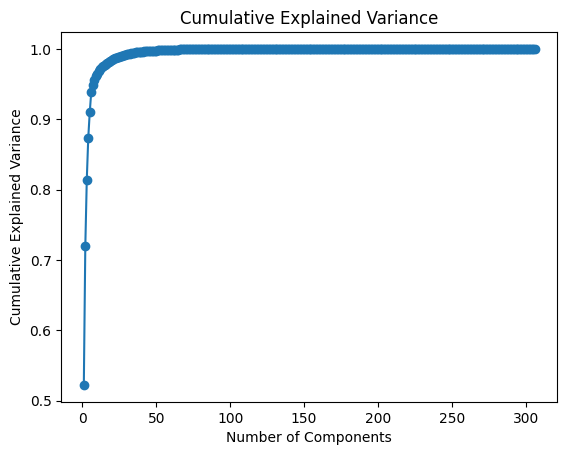

In [35]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
plt.plot(np.arange(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.show()

In [36]:
r2_df = []
for i in range (1, 300):
    pca = PCA(i)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    lr = LogisticRegression()
    lr.fit(X_train_pca, y_train)
    y_pred = lr.predict(X_test_pca)
    r2_df.append([i, accuracy_score(y_test, y_pred)])
r2_df = pd.DataFrame(r2_df, columns=["PCs", "accuracy_score"])
print(r2_df.sort_values(by=['accuracy_score'], ascending=False).head(10))

c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

     PCs  accuracy_score
149  150        0.986319
169  170        0.986319
227  228        0.986319
229  230        0.986319
271  272        0.986319
177  178        0.986319
269  270        0.986319
230  231        0.986319
267  268        0.986319
263  264        0.986319


c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
pca = PCA(150)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [49]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train_pca.shape[1],)))
    for i in range (0, hp.Int('layers', 1, 3)):
        model.add(layers.Dense(units=hp.Int('unit_' + str(i + 1), min_value=2, max_value=100, step=2)
                               , activation=hp.Choice('act_'+str(i + 1), ['relu', 'tanh'])))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                    loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model
tuner = RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 10,
    executions_per_trial = 3,
)
tuner.search(X_train_pca, y_train, epochs=170, validation_split=0.1, batch_size=128)

Trial 10 Complete [00h 02m 57s]
val_accuracy: 0.9946581125259399

Best val_accuracy So Far: 0.995726486047109
Total elapsed time: 00h 32m 41s


In [50]:
print(tuner.results_summary())

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
layers: 1
unit_1: 40
act_1: relu
unit_2: 8
act_2: relu
unit_3: 98
act_3: relu
Score: 0.995726486047109

Trial 05 summary
Hyperparameters:
layers: 1
unit_1: 98
act_1: relu
unit_2: 10
act_2: tanh
unit_3: 58
act_3: relu
Score: 0.9953703681627909

Trial 02 summary
Hyperparameters:
layers: 1
unit_1: 54
act_1: relu
unit_2: 78
act_2: tanh
unit_3: 52
act_3: relu
Score: 0.995370348294576

Trial 00 summary
Hyperparameters:
layers: 3
unit_1: 92
act_1: tanh
unit_2: 2
act_2: relu
unit_3: 2
act_3: relu
Score: 0.9946581125259399

Trial 09 summary
Hyperparameters:
layers: 1
unit_1: 90
act_1: relu
unit_2: 48
act_2: relu
unit_3: 96
act_3: relu
Score: 0.9946581125259399

Trial 06 summary
Hyperparameters:
layers: 1
unit_1: 88
act_1: relu
unit_2: 66
act_2: relu
unit_3: 24
act_3: relu
Score: 0.994301974773407

Trial 07 summary
Hyperparameters:
layers: 3
unit

In [71]:
# Tạo mô hình
model = keras.Sequential([
    layers.Input(shape=(X_train_pca.shape[1])),
    layers.Dense(40, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(98, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
# Đóng gói mô hình
model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])
# Huấn luyện mô hình
history = model.fit(X_train_pca, y_train, epochs=20, batch_size=128, validation_split=0.1)

Epoch 1/20
66/66 [==============================] - 3s 10ms/step - loss: 0.3657 - accuracy: 0.8585 - val_loss: 0.1515 - val_accuracy: 0.9519
Epoch 2/20
66/66 [==============================] - 0s 4ms/step - loss: 0.1123 - accuracy: 0.9596 - val_loss: 0.0875 - val_accuracy: 0.9669
Epoch 3/20
66/66 [==============================] - 0s 4ms/step - loss: 0.0741 - accuracy: 0.9745 - val_loss: 0.0642 - val_accuracy: 0.9733
Epoch 4/20
66/66 [==============================] - 0s 3ms/step - loss: 0.0538 - accuracy: 0.9836 - val_loss: 0.0494 - val_accuracy: 0.9818
Epoch 5/20
66/66 [==============================] - 0s 4ms/step - loss: 0.0447 - accuracy: 0.9859 - val_loss: 0.0457 - val_accuracy: 0.9797
Epoch 6/20
66/66 [==============================] - 0s 4ms/step - loss: 0.0359 - accuracy: 0.9886 - val_loss: 0.0440 - val_accuracy: 0.9840
Epoch 7/20
66/66 [==============================] - 0s 3ms/step - loss: 0.0308 - accuracy: 0.9899 - val_loss: 0.0378 - val_accuracy: 0.9850
Epoch 8/20
66/66 [=

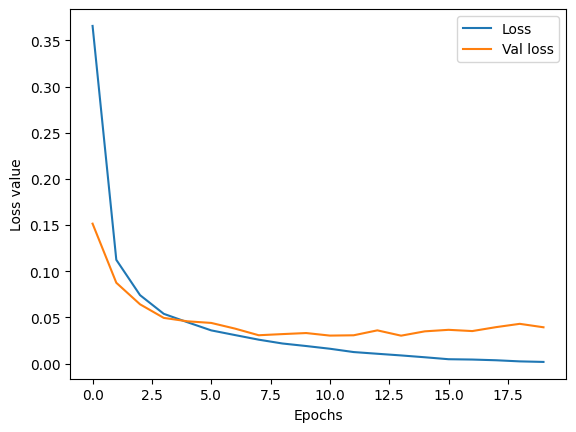

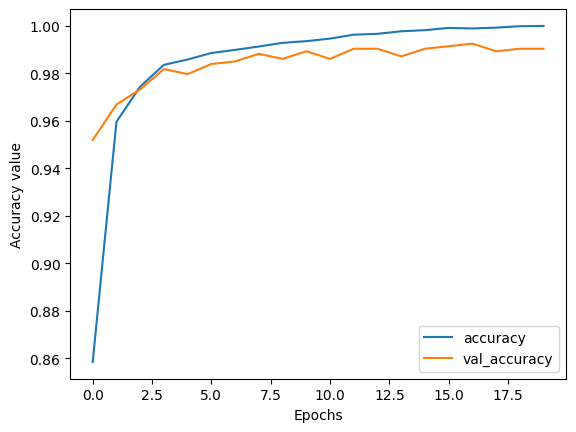

In [74]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy value')
plt.legend()
plt.show()

74/74 [==============================] - 0s 2ms/step
0.9880290722530997
0.96
0.9696969696969697
0.964824120603015


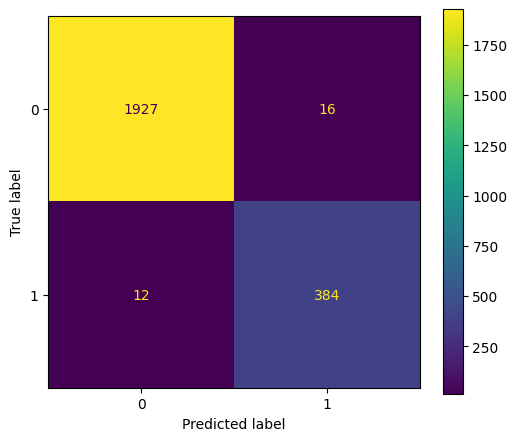

In [78]:
y_pred = model.predict(X_test_pca)
# Đặt ngưỡng 0.5
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()

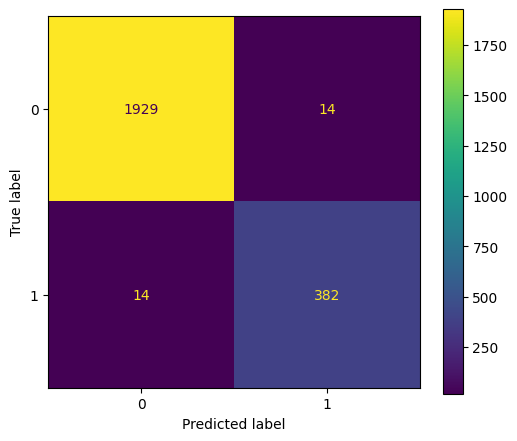

In [54]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()

In [55]:
precision_score(y_test, y_pred)

0.9646464646464646

In [58]:
recall_score(y_test, y_pred)

0.9646464646464646

In [56]:
f1_score(y_test, y_pred)

0.9646464646464646